####  Taylor Examples 5.49

last revised: 17-Jan-2019 by Dick Furnstahl [furnstahl.1@osu.edu]


Here we are exploring the Fourier series for a waveform defined to be even about the origin, so $f(-t) = +f(t)$, with period $\tau$.  That means that the integrand for the $b_m$ coefficients is odd and so all of the corresponding integrals vanish.  

The particular wave of interest here is a periodic rectangular pulse, such that in the interval $-\tau/2 \leq t \leq \tau/2$, the function takes the form:

$\newcommand{\fmax}{f_{\textrm{max}}}$
$\begin{align}
  f(t) = \left\{ \begin{array}{lc}
                   \fmax & -\Delta\tau/2 < t < \Delta\tau/2 \\
                   0 & |t| > \Delta\tau/2 
                 \end{array}
                   \right.
\end{align}$

As usual, we do the $a_0$ integral separately and then $a_m$ for $m \geq 1$.  Here $\omega \equiv 2\pi/\tau$.  The results are (also see the text):

$\begin{align}
  a_0 = \frac{1}{\tau} \int_{-\tau/2}^{\tau/2} f(t)\, dt = \frac{\fmax\Delta\tau}{\tau}
\end{align}$

$\begin{align}
  a_m = \frac{2}{\tau} \int_{-\tau/2}^{\tau/2} \cos(m\omega t) f(t)\, dt = 
      \frac{4\fmax}{\tau} \int_0^{\Delta\tau/2} \cos(2\pi m t/\tau) \, dt 
    %  &= - \frac{2\fmax}{m\pi}\left[\cos(m\pi t)\right]^1_0 \\
      =
        \frac{2 \fmax}{m\pi} \sin\left(\frac{\pi m \Delta\tau}{\tau}\right)
\end{align}$


## Define the functions we'll need

In [183]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

We start by defining a function for the rectangular pulse at any $t$.  The definition here is for a scalar function.  That is, it won't work to call it with $t$ and array of time points, unlike other functions we have defined.  It is possible to make it work, but then the function will be much less clear.  When we need to evaluate it for all elements of an array `t_pts`, we will use the construction: <br/> `np.array([rectangular(t) for t in t_pts])`.

In [184]:
def rectangular(t, tau=1., Delta_tau=0.25, f_max=1.):
    """Returns the triangular wave of amplitude f_max and even about the 
        origin at time t.  The period is tau.  It is defined as a scalar 
        function (i.e., only one value of t can be passed at a time). 
        **There must be a better way to define this!**
    """
    t_adjust = t - round(t)  # shift t so we can test for being within Delta_tau
        
    if np.fabs(t_adjust) < Delta_tau/2.:
        return f_max
    else:
        return 0. 

def triangular(t, tau, f_max=1):
    """Returns the triangular wave of amplitude f_max and even about the 
    origin at time t. The period is tau. It is defined as a scalar 
    function (i.e., only one value of t can be passed at a time). 
    """
    if np.floor(t) % 2 == 0:
        t_adjust = t - np.floor(t)
        return 1. - 2.*t_adjust / tau
    else:
        t_adjust = t - (np.floor(t) + 1)
        return 1. + 2.*t_adjust / tau

 

Now a function that creates an array of Fourier coefficients for the triangular wave up to order N_max.

In [185]:
def triangular_coeffs_by_hand(N_max, tau=1., f_max=1):
    """Fourier coefficients calculated by hand and loaded into an array
        as pairs in the form (a_n, b_n).  
    """
    # initialize the array with the vaues of a_0 and b_0
    coeffs_array = [(f_max/2., 0)] 
    for n in np.arange(1, N_max, 1):
        # these are pre-calcualated values of a_n and b_n
        a_n = f_max*2.*(1-(-1)**n)/(n**2 * np.pi**2)
        b_n = 0.
        coeffs_array.append((a_n, b_n))  # add them to the end of the array   
    return np.array(coeffs_array)  # convert to a numpy array to be safe


We would like a general way to construct the array of Fourier coefficients given any periodic function.  Our first pass at that uses a class definition and the scipy integration function quad. 

In [186]:
class FourierSeries():
    """
    Fourier series class finds the coefficients in a Fourier series with
    period tau up to a specified order.
    Assume these imports:
        from scipy.integrate import quad
        import numpy as np
    ***Need to add args to the function.***     
    """
    def __init__(self,
                 function,
                 tau=1.,
                 N_max=10
                ):
        self.function = function
        self.tau = tau
        self.omega = 2. * np.pi / tau    
        self.N_max = N_max
        # add something to quit if Nmax < 0 or not an integer (try and except)

    def a0_calc(self):
        """Calculate the constant Fourier coefficient by integration"""
        answer, error = quad(self.function, -tau/2., tau/2., args=(tau,))
        return (1./self.tau) * answer
    
    def an_integrand(self, t, n):
        """Integrand for the nth cosine coefficient"""
        return self.function(t, tau) * np.cos(n * self.omega * t)
    
    def an_calc(self, n):
        """Calculate the nth cosine coefficient (n > 0)"""
        # note comma after n in args
        answer, error = quad(self.an_integrand, -tau/2., tau/2., args=(n,))  
        return (2./self.tau) * answer
    
    def bn_integrand(self, t, n):
        """Integrand for the nth cosine coefficient"""
        return self.function(t, tau) * np.sin(n * self.omega * t)
    
    def bn_calc(self, n):
        """Calculate the nth cosine coefficient (n > 0)"""
        answer, error = quad(self.bn_integrand, -tau/2., tau/2., args=(n,))  
        return (2./self.tau) * answer
        
    def coeffs_upto_Nmax(self):
        """Calculate the Fourier series up to Nmax"""
        # first generate the coefficient
        coeffs_array = [(self.a0_calc(), 0)]   # a_0 and b_0
        
        for n in np.arange(1, N_max, 1):
            a_n = self.an_calc(n)
            b_n = self.bn_calc(n)
            coeffs_array.append((a_n, b_n))  # append a tuple of coefficients
    
        return np.array(coeffs_array)  # convert to a numpy array  
    

Finally, we need a function that can take as input an array of t values and an array of Fourier coefficients and return the function at those t values with terms up to order N_max. 

In [187]:

def Fourier_reconstruct(t_pts, coeffs_array, tau, N_max):
    """Sum up the Fourier series up to n = N_max terms."""
    omega = 2. * np.pi / tau   # definition of omega
    result = 0.
    # iterate over coefficients but only up to N_max
    for n, (a,b) in enumerate(coeffs_array[:N_max+1]):  
        result = result + a * np.cos(n * omega * t_pts) \
                        + b * np.sin(n * omega * t_pts)
    return result    

## Example 5.4

Ok, now we can do Example 5.4.  Calculate the coefficients both ways.

In [188]:
N_max = 20
tau = 2.
f_max = 1.

coeffs_by_hand = triangular_coeffs_by_hand(N_max, tau, f_max)

fs = FourierSeries(triangular, tau, N_max)
coeffs_by_quad = fs.coeffs_upto_Nmax()

Let's check that the exact and numerical calculation of the coefficients agree.  

(Note the space in the formats below, e.g., `{a1: .6f}`.  This means to leave an extra space for a positive number so that it aligns at the decimal point with negative numbers.)

In [189]:
print(' n   a_exact     a_quad      b_exact     b_quad')
for n, ((a1,b1), (a2,b2)) in enumerate(zip(coeffs_by_hand, coeffs_by_quad)):
    print(f'{n:2d}  {a1: .6f}  {a2: .6f}    {b1: .6f}  {b2: .6f}')

 n   a_exact     a_quad      b_exact     b_quad
 0   0.500000   0.500000     0.000000   0.000000
 1   0.405285   0.405285     0.000000   0.000000
 2   0.000000  -0.000000     0.000000   0.000000
 3   0.045032   0.045032     0.000000   0.000000
 4   0.000000   0.000000     0.000000   0.000000
 5   0.016211   0.016211     0.000000   0.000000
 6   0.000000  -0.000000     0.000000   0.000000
 7   0.008271   0.008271     0.000000   0.000000
 8   0.000000  -0.000000     0.000000   0.000000
 9   0.005004   0.005004     0.000000   0.000000
10   0.000000  -0.000000     0.000000   0.000000
11   0.003349   0.003349     0.000000   0.000000
12   0.000000  -0.000000     0.000000   0.000000
13   0.002398   0.002398     0.000000   0.000000
14   0.000000  -0.000000     0.000000   0.000000
15   0.001801   0.001801     0.000000   0.000000
16   0.000000  -0.000000     0.000000   0.000000
17   0.001402   0.001402     0.000000   0.000000
18   0.000000   0.000000     0.000000   0.000000
19   0.001123   0.001

Make the comparison plot requested: N_max = 2 vs. N_max = 6.

In [190]:
t_pts = np.arange(-2., 4., .01)
f_pts_2 = Fourier_reconstruct(t_pts, coeffs_by_hand, tau, 2)
f_pts_6 = Fourier_reconstruct(t_pts, coeffs_by_hand, tau, 6)

# Python way to evaluate the rectangular function at an array of points:
#   * np.array creates a numpy array;
#   * note the []s around the inner statement;
#   * rectangular(t) for t in t_pts  
#       means step through each element of t_pts, call it t, and
#       evaluate rectangular at that t.
#   * This is called a list comprehension.  There are more compact ways,
#      but this is clear and easy to debug.
triangular_t_pts = np.array([triangular(t, tau, f_max) for t in t_pts])

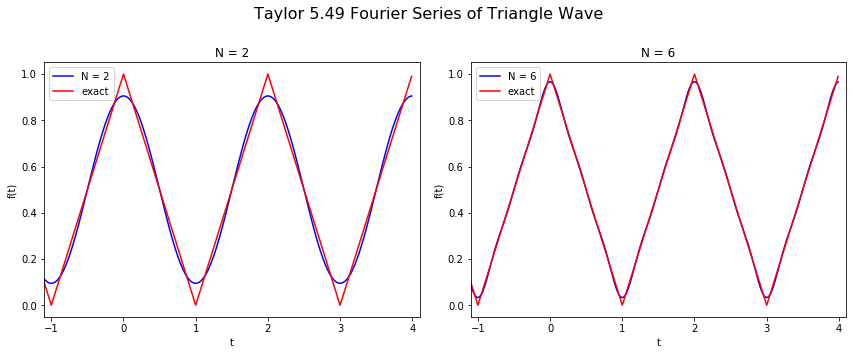

In [193]:
# It looks like we should define a function for the axis!

fig_1 = plt.figure(figsize=(12,5))

ax_1 = fig_1.add_subplot(1,2,1)
ax_1.plot(t_pts, f_pts_2, label='N = 2', color='blue')
ax_1.plot(t_pts, triangular_t_pts, label='exact', color='red')
ax_1.set_xlim(-1.1,4.1)
ax_1.set_xlabel('t')
ax_1.set_ylabel('f(t)')
ax_1.set_title('N = 2')
ax_1.legend()

ax_2 = fig_1.add_subplot(1,2,2)
ax_2.plot(t_pts, f_pts_6, label='N = 6', color='blue')
ax_2.plot(t_pts, triangular_t_pts, label='exact', color='red')
ax_2.set_xlim(-1.1,4.1)
ax_2.set_xlabel('t')
ax_2.set_ylabel('f(t)')
ax_2.set_title('N = 6')
ax_2.legend();


fig_1.suptitle("Taylor 5.49 Fourier Series of Triangle Wave", fontsize=16)
fig_1.tight_layout(rect=[0, 0.003, 1, 0.9])
fig_1.savefig('Taylor_5.49.png')

## Example 5.5

We consider a driven oscillator with an even driving force so only cosine terms are non-zero in the Fourier transform of $f(t)$.  Linearity of the equation then means that the solution takes the form

$\begin{align}
  x(t) = \sum_{n=0}^{\infty} A_n \cos(n\omega t - \delta_n) \;,
\end{align}$

where

$\begin{align}
  A_n &= \frac{f_n}{\sqrt{(\omega_0^2 - n^2 \omega^2)^2 + 4\beta^2 n^2 \omega^2}}  \\
  \delta_n &= \arctan\left(\frac{2\beta n\omega}{\omega_0^2 - n^2 \omega^2}  \right)
\end{align}$


For Example 5.5 we apply this to the rectangular driving force, so we can use the coefficients from Example 5.4, which play the role of the $f_n$ coefficients here.

In [194]:
def driven_coefficients(tau_0, tau, beta, coeffs):
    """Calculate the coefficients A_n and delta_n for a driven oscillator."""
    omega_0 = 2. * np.pi / tau_0
    omega = 2. * np.pi / tau
    
    A_n = []
    delta_n = []
    
    # the second entry in the tuple is called dummy because it is not used
    for n, (f_n, dummy) in enumerate(coeffs):
        A_n.append(f_n / np.sqrt((omega_0**2 - n**2 * omega**2)**2 + 
                                  (2. * beta * n *omega)**2))
        delta_n.append(np.arctan2(2. * beta * n *omega, 
                                  omega_0**2 - n**2 * omega**2 ))  
    return np.array(A_n), np.array(delta_n)
    
def x_drive(t_pts, tau_0, tau, beta, N_max, coeffs): 
    """Sum up the Fourier series for x(t) up to n = N_max terms."""
    omega = 2. * np.pi / tau
    A_n_array, delta_n_array = driven_coefficients(tau_0, tau, beta, coeffs) 
    
    result = 0.
    # iterate over coefficients but only up to N_max
    for n, (A_n, delta_n) in enumerate(zip(A_n_array[:N_max+1], 
                                           delta_n_array[:N_max+1])): 
        result = result + A_n * np.cos( n * omega * t_pts - delta_n)
    return result    

Ok, let's do Example 5.5!  

In [195]:
N_max = 20
tau = 2
f_max = 1.
coeffs_by_hand = triangular_coeffs_by_hand(N_max, tau, f_max)


In [196]:
t_pts = np.arange(0., 7., .01)

# first set of parameters
N_max = 20
f_max = 1.
Delta_tau = 0.25
tau = 2.
coeffs_by_hand_1 = triangular_coeffs_by_hand(N_max, tau, f_max)

tau_0_1 = 1.
beta = 0.2
A_n_array_1, delta_n_array_1 = driven_coefficients(tau_0_1, tau, beta, 
                                                   coeffs_by_hand_1) 
x_pts_1 = x_drive(t_pts, tau_0_1, tau, beta, N_max, coeffs_by_hand_1)


# now only tau is varied
tau = 1.5
coeffs_by_hand_2 = triangular_coeffs_by_hand(N_max, tau, f_max)

tau_0_2 = 1.
beta = 0.2
A_n_array_2, delta_n_array_2 = driven_coefficients(tau_0_2, tau, beta, 
                                                   coeffs_by_hand_2) 
x_pts_2 = x_drive(t_pts, tau_0_2, tau, beta, N_max, coeffs_by_hand_2)


Compare coefficients for the cases from part (a) and part (b): very different $A_1$ coefficients.

In [197]:
print(' n     case a         case b')
for n, (A_n_1, A_n_2) in enumerate(zip(A_n_array_1, A_n_array_2)):
    print(f'{n:2d}   {A_n_1: .8f}   {A_n_2: .8f}')

 n     case a         case b
 0    0.01266515    0.01266515
 1    0.01367567    0.01842508
 2    0.00000000    0.00000000
 3    0.00090988    0.00037988
 4    0.00000000    0.00000000
 5    0.00007818    0.00004060
 6    0.00000000    0.00000000
 7    0.00001862    0.00001008
 8    0.00000000    0.00000000
 9    0.00000658    0.00000362
10    0.00000000    0.00000000
11    0.00000290    0.00000161
12    0.00000000    0.00000000
13    0.00000147    0.00000082
14    0.00000000    0.00000000
15    0.00000083    0.00000046
16    0.00000000    0.00000000
17    0.00000050    0.00000028
18    0.00000000    0.00000000
19    0.00000032    0.00000018


Now for the graphs requested:

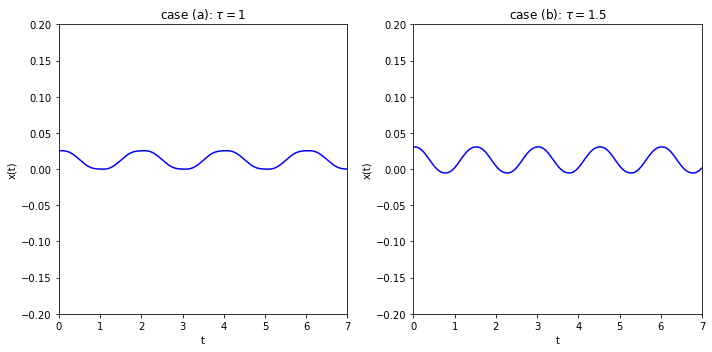

In [198]:
fig_2 = plt.figure(figsize=(10,5))

ax_1 = fig_2.add_subplot(1,2,1)
ax_1.plot(t_pts, x_pts_1, color='blue')
ax_1.set_xlim(0., 7.)
ax_1.set_ylim(-0.2, 0.2)
ax_1.set_xlabel('t')
ax_1.set_ylabel('x(t)')
ax_1.set_title(r'case (a): $\tau = 1$')

ax_2 = fig_2.add_subplot(1,2,2)
ax_2.plot(t_pts, x_pts_2, color='blue')
ax_2.set_xlim(0., 7.)
ax_2.set_ylim(-0.2, 0.2)
ax_2.set_xlabel('t')
ax_2.set_ylabel('x(t)')
ax_2.set_title(r'case (b): $\tau = 1.5$')

fig_2.tight_layout()
fig_2.savefig('problem_5.53.png')

To add the additional graphs with more $\tau$ values, we should define a function that produces the plot given a $\tau$.